In [1]:
import contextlib
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords, wordnet
import contextlib
import string
import nltk
import json

import spacy
import lemminflect
nltk.download('punkt_tab')
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
POS = ("CC", "CD", "DT", "EX", "FW", "IN", "JJ", "JJR", "JJS", "LS", "MD", "NN", "NNP", "NNPS", "NNS", "PDT", "PRP", "PRP$", "RB", "RBR", "RBS", "RP", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ", "WDT", "WP", "WP$", "WRB")

def lemmatize(word): # Takes a word and uses the spacy lemmatizer to return the lemmatized form
    token = nlp(str(word))[0]
    lemma = token.lemma_
    inflections = {token._.inflect(pos) for pos in POS} # returns the inflection of the lemmatized token. (ex: run -> {'ran', 'run', 'runner', 'runnest', 'running', 'runs'} )
    return lemma, inflections

def tokenize(sentence): # Tokenizes a sentence and lemmatizes the words within
    tokenized = nlp(sentence.translate(str.maketrans('', '', string.punctuation)))
    return [token.lemma_ for token in tokenized if token.lemma_.lower() not in en_stopwords and wordnet.synsets(token.lemma_)] # disregards lemmatized token if it's in list of stopwords or not in english dictionary (wordnet)

nltk.download('stopwords')
nltk.download('wordnet')
en_stopwords = set(stopwords.words('english'))

data = [] # loads the datasets as binaries 
for i in range (1, 1731):
    with contextlib.suppress(FileNotFoundError):
        with open(f'data/fairy_tales/{i}.txt', 'r', encoding='ISO-8859-1') as f:
            data.append(f.read())

/Users/Yourui/Documents/bloom-filters-jasmine/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/Yourui/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Yourui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Yourui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
neighbor_frequencies = {}
total_frequencies = {}
tokenized_corpus = []
deltas = [-4, -3, -2, -1, 1, 2, 3, 4]
words_in_corpus = 0

In [3]:
def update_total_frequencies(word): # updates the freq of word in the entire corpus
    try:
        total_frequencies[word] += 1
    except KeyError:
        total_frequencies[word] = 1 # if not in list already, add to list and set freq to 1

def update_neighbor_frequencies(i, tokenized): # given a tokenized sentence, updates the freq of words next to the word at index i
    if tokenized[i] not in neighbor_frequencies.keys(): # creates a dictionary for word at index i if it doesn't already exist
        neighbor_frequencies[tokenized[i]] = {}
    for delta in deltas: # for the 4 words before and after index i
        if i + delta < 0: # skip wrap-arounds
            continue
        with contextlib.suppress(IndexError): # if a word at the 4 indices before and after i doesn't exist, just ignore
            try:
                neighbor_frequencies[tokenized[i]][tokenized[i+delta]] += 1
            except KeyError:
                neighbor_frequencies[tokenized[i]][tokenized[i+delta]] = 1

In [4]:
for i, row in enumerate(data):
    try: 
        sentences = sent_tokenize(row.lower()) # converts to lowercase, sent_tokenize tokenizes the document into individual sentences by punctuation
    except UnicodeDecodeError:
        sentences = sent_tokenize(row.lower())
    
    for sentence in sentences: # for each sentence in the document
        tokenized = tokenize(sentence)
        if len(tokenized) > 1: # drops 1-word sentences
            tokenized_corpus.append(tokenized)
            words_in_corpus += len(tokenized)
            for token_index in range(len(tokenized)): # for each word (ex: 'trick' (see the first printed output)) in tokenized sentence, update the freq of the adjacent words ('long', 'ramble', 'belgium', 'storyteller', 'find' for that word)
                update_total_frequencies(tokenized[token_index]) # updates the freq of the word at that index in the entire corpus (here, 'trick')
                update_neighbor_frequencies(token_index, tokenized)

In [5]:
n_neighbors = {word:sum(neighbor_frequencies[word].values()) for word in neighbor_frequencies.keys()}

In [6]:
import copy
import math
tf_idfs = copy.deepcopy(neighbor_frequencies) # make copy of the relative frequencies json to convert frequencies to tf-idfs
for word in neighbor_frequencies.keys(): # ex: "queen"
    for neighbor in neighbor_frequencies[word].keys(): # The words next to "queen", i.e. "lady", "fairy", "king", etc.
        tf_idfs[word][neighbor] = neighbor_frequencies[word][neighbor] / n_neighbors[word]  * math.log(words_in_corpus / n_neighbors[neighbor])

for word in tf_idfs.keys():
    tf_idfs[word] = dict(sorted(tf_idfs[word].items(), key=lambda item: item[1], reverse=True)) # sorts TF-IDFs in decreasing order

In [7]:
with open('data/fairytales_word_tf-idfs.json', 'w') as f:
    json.dump(tf_idfs, f, indent=4)
with open('data/fairytales_tokenized.json', 'w') as f:
    json.dump(tokenized_corpus, f, indent=4)

In [13]:
import matplotlib.pyplot as plt
def plot_tf_idf_distribution(tf_idfs, title, bounds=(0,1)):
    all_values = []
    for word in tf_idfs.keys():
        all_values.extend(tf_idfs[word].values())

    plt.figure(figsize=(10, 6))
    plt.hist(all_values, bins=50, range=bounds, edgecolor='black')
    plt.title(title)
    plt.xlabel('TF-IDF')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()

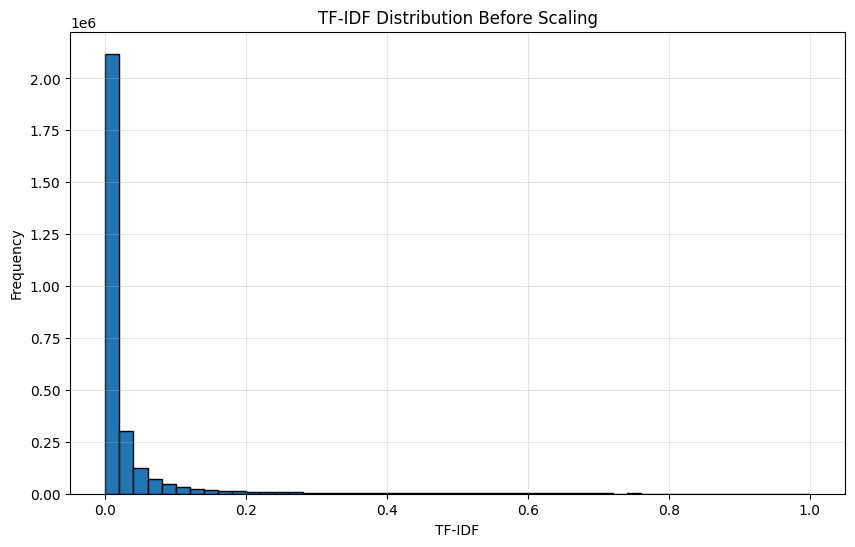

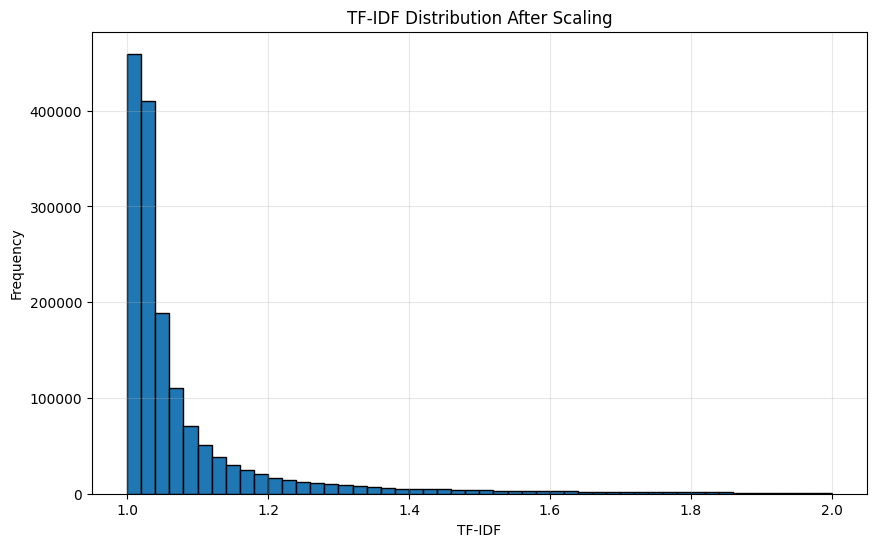

In [14]:
import json

# scaling TF-IDFs
drop = lambda x: 0 if x < 0.005 else (1+x)**2
with open('data/fairytales_word_tf-idfs.json', 'r') as f:
    tf_idfs = json.load(f)
    plot_tf_idf_distribution(tf_idfs, 'TF-IDF Distribution Before Scaling')
    for word in tf_idfs.keys():
        for neighbor in tf_idfs[word].keys():
            tf_idfs[word][neighbor] = drop(tf_idfs[word][neighbor])
    plot_tf_idf_distribution(tf_idfs, 'TF-IDF Distribution After Scaling', (1,2))
with open('data/fairytales_word_tf-idfs_drop.json', 'w+') as f:
    json.dump(tf_idfs, f, indent=4)